In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from collections import Counter
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import balanced_accuracy_score, roc_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import plot_tree

from imblearn.combine import SMOTEENN

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the cleaned dataset
data = pd.read_csv('Processed_Telecom_Churn.csv')

# Display the first few rows to inspect the data
data.head()

,telecom_partner,gender,age,state,city,pincode,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn,tenure_days
0,2,0,25,10,4,755597,4,124962,44.0,45.0,5112.0,0,1879
1,2,0,55,16,5,125926,2,130556,62.0,39.0,5973.0,0,1879
2,3,0,57,1,2,423976,0,148828,49.0,24.0,193.0,1,1879
3,1,1,46,22,4,522841,1,38722,80.0,25.0,9377.0,1,1879
4,1,0,26,24,2,740247,2,55098,78.0,15.0,1393.0,0,1879


In [3]:
X = data.drop(columns=['churn'])
y = data['churn']
X.head()

,telecom_partner,gender,age,state,city,pincode,num_dependents,estimated_salary,calls_made,sms_sent,data_used,tenure_days
0,2,0,25,10,4,755597,4,124962,44.0,45.0,5112.0,1879
1,2,0,55,16,5,125926,2,130556,62.0,39.0,5973.0,1879
2,3,0,57,1,2,423976,0,148828,49.0,24.0,193.0,1879
3,1,1,46,22,4,522841,1,38722,80.0,25.0,9377.0,1879
4,1,0,26,24,2,740247,2,55098,78.0,15.0,1393.0,1879


In [4]:
from sklearn.feature_selection import mutual_info_classif
# Calculate MI Scores
mi_scores = mutual_info_classif(X, y, random_state=42)

# Create DataFrame for MI Scores
mi_data = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_data.sort_values(by='MI Score', ascending=False, inplace=True)

# Display feature importance
print("Mutual Information Scores:")
print(mi_data)


Mutual Information Scores:
             Feature  MI Score
1             gender  0.034000
0    telecom_partner  0.008496
6     num_dependents  0.007420
4               city  0.007142
3              state  0.001827
10         data_used  0.001299
11       tenure_days  0.001246
9           sms_sent  0.000604
8         calls_made  0.000206
2                age  0.000000
5            pincode  0.000000
7   estimated_salary  0.000000


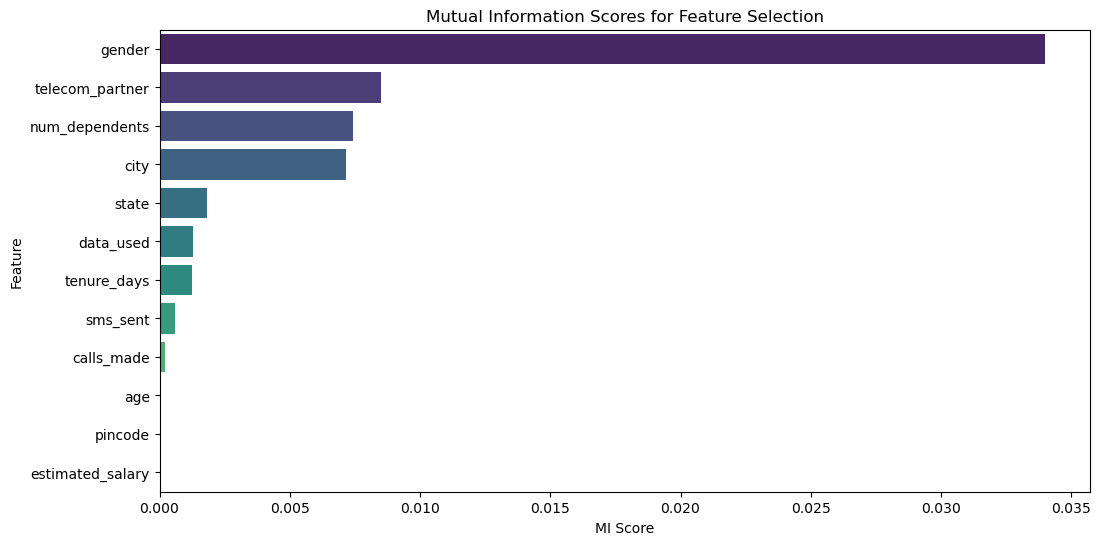

In [5]:
# Visualize MI Scores
plt.figure(figsize=(12, 6))
sns.barplot(x='MI Score', y='Feature', data=mi_data, palette='viridis')
plt.title('Mutual Information Scores for Feature Selection')
plt.show()

In [6]:
# Select Features with MI Score > 0.01
selected_features = mi_data[mi_data['MI Score'] > 0]['Feature'].tolist()
X = X[selected_features]

print("Selected Features:", selected_features)

Selected Features: ['gender', 'telecom_partner', 'num_dependents', 'city', 'state', 'data_used', 'tenure_days', 'sms_sent', 'calls_made']


In [7]:
# Class Distribution Before SMOTEENN
print("Class distribution before SMOTEENN:", Counter(y))

# Apply SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X, y)

# Class Distribution After SMOTEENN
print("Class distribution after SMOTEENN:", Counter(y_train_resampled))

Class distribution before SMOTEENN: Counter({0: 194726, 1: 48827})
Class distribution after SMOTEENN: Counter({1: 149003, 0: 78304})


In [8]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X_train_resampled)

In [11]:
# Perform stratified train-test split to maintain the class distribution
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_train_resampled, test_size=0.2, random_state=42, stratify=y_train_resampled)

In [12]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (181845, 9)
X_test shape: (45462, 9)


In [13]:
#List to store models
models = []

In [14]:
# Function to print the evaluation metrics
def eval_metrics(model, X_test, y_test):
    y_pred_model = model.predict(X_test)    
    y_probabilities = model.predict_proba(X_test)[:, 1]
    
    print('Precision: ', precision_score(y_test, y_pred_model))
    print('Recall: ', recall_score(y_test, y_pred_model))
    print('F1 Score: ', f1_score(y_test, y_pred_model))
    print('ROC AUC Score: ', roc_auc_score(y_test, y_probabilities))
    
    plt.figure(figsize=(12,6))
    
    # Confusion matrix
    plt.subplot(121)
    conf_mat = confusion_matrix(y_test, y_pred_model)
    sns.heatmap(conf_mat, fmt="d", annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    # ROC AUC Score
    model_roc_auc = roc_auc_score(y_test, y_probabilities) 
    fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)
    
    plt.subplot(122)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label="AUC : %.3f" % model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    plt.show()

Precision:  0.6918989015459723
Recall:  0.9130901647595718
F1 Score:  0.7872528171968348
ROC AUC Score:  0.6605474252648564


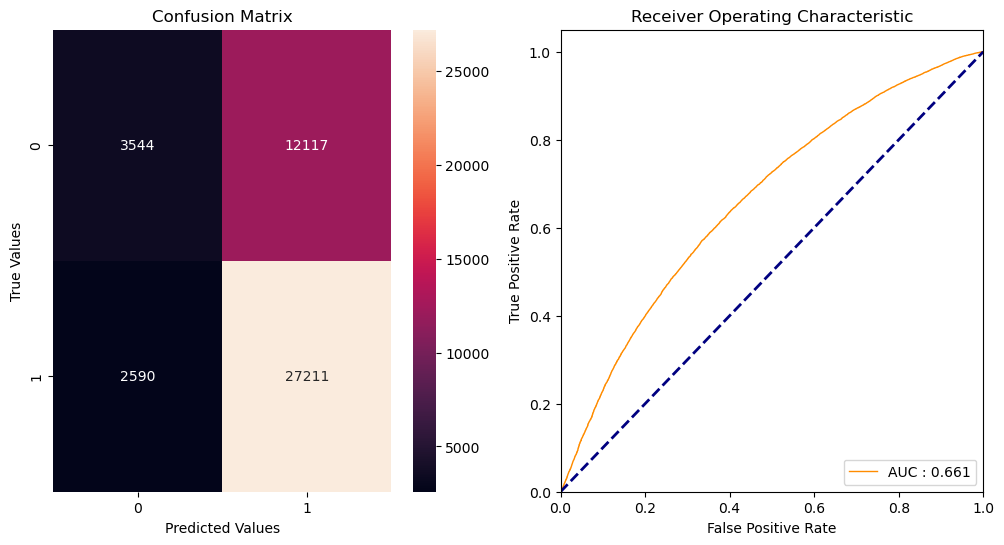

In [15]:
# Initialize and fit different models
# 1. Logistic Regression
churn_lr = LogisticRegression(random_state=42, max_iter=1000)
churn_lr.fit(X_train, y_train)
models.append(churn_lr)
eval_metrics(churn_lr, X_test, y_test)

Precision:  0.8222848615486652
Recall:  0.8320526156840374
F1 Score:  0.8271399025952364
ROC AUC Score:  0.744932507956954


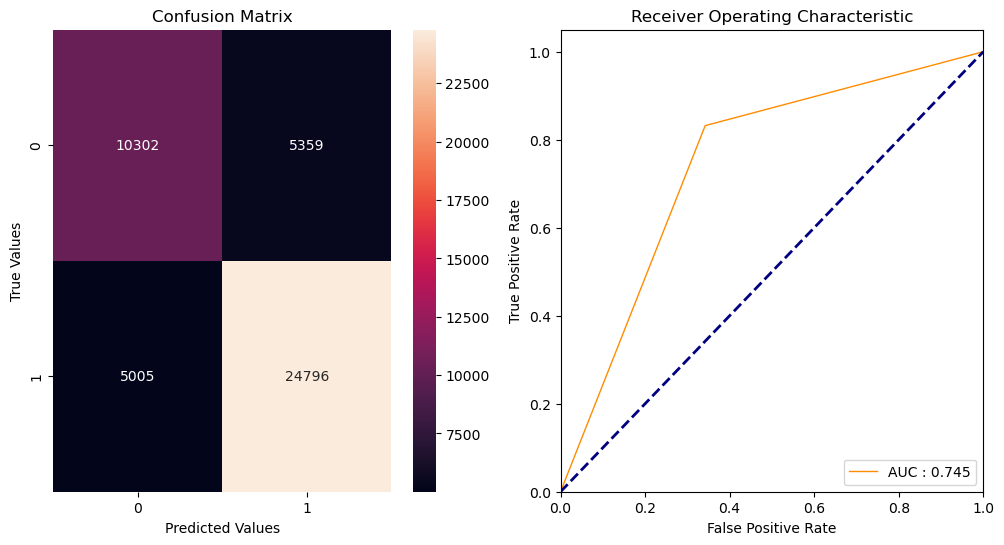

In [16]:
# 2. DecisionTreeClassifier
churn_DT = DecisionTreeClassifier(random_state=42)
churn_DT.fit(X_train, y_train)
models.append(churn_DT)
eval_metrics(churn_DT, X_test, y_test)

Precision:  0.7176293751342065
Recall:  0.8971511023120029
F1 Score:  0.7974111576718315
ROC AUC Score:  0.7189135669690916


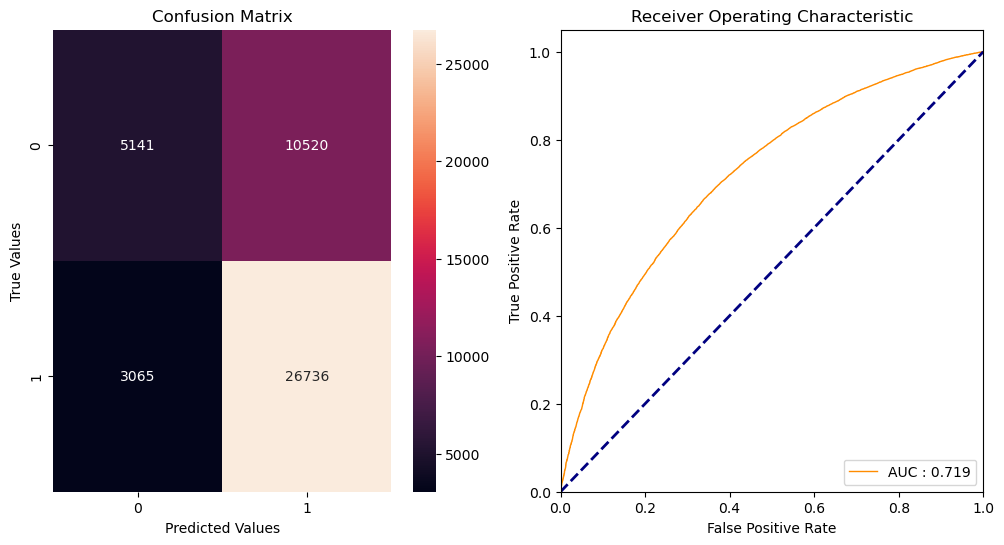

In [17]:
# 3. Gaussian Naive Bayes
churn_GNB = GaussianNB()
churn_GNB.fit(X_train, y_train)
models.append(churn_GNB)
eval_metrics(churn_GNB, X_test, y_test)

Precision:  0.7973575049930864
Recall:  0.8707761484513943
F1 Score:  0.8324511596573957
ROC AUC Score:  0.8491295561753681


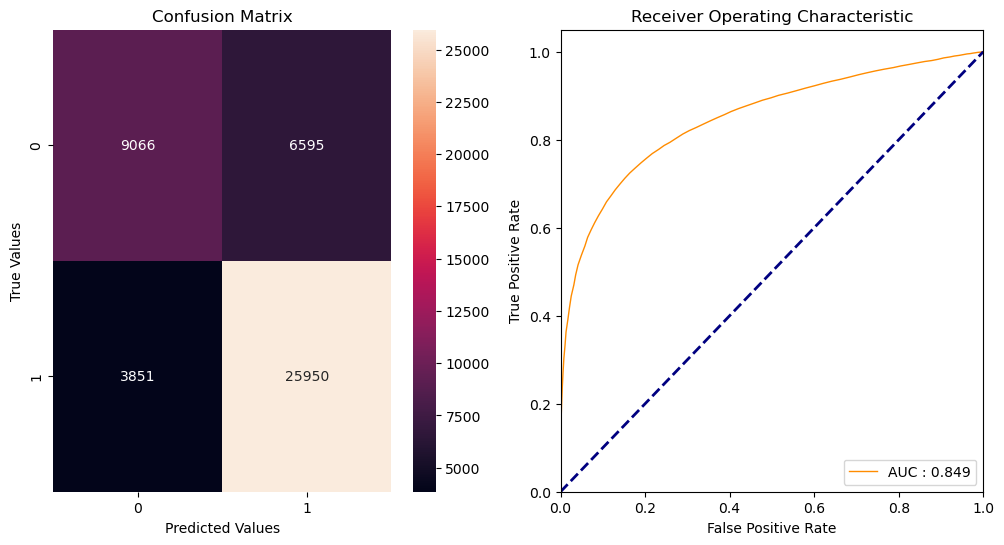

In [18]:
# 4. Random Forest
churn_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
churn_rf.fit(X_train, y_train)
models.append(churn_rf)
eval_metrics(churn_rf, X_test, y_test)

Precision:  0.752086623054365
Recall:  0.895003523371699
F1 Score:  0.8173446717229755
ROC AUC Score:  0.8068589015905843


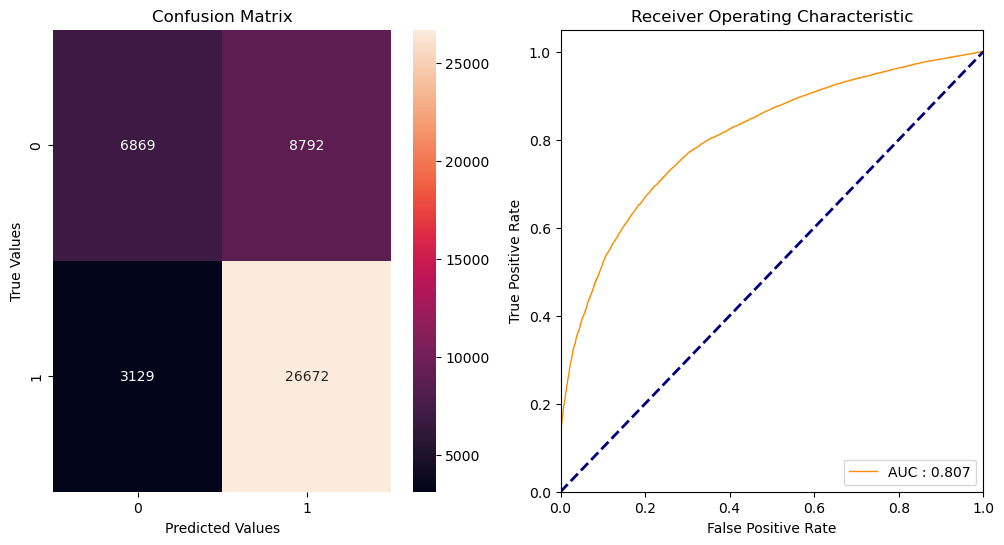

In [19]:
# 5. Gradient Boosting
churn_gb = GradientBoostingClassifier(random_state=42)
churn_gb.fit(X_train, y_train)
models.append(churn_gb)
eval_metrics(churn_gb, X_test, y_test)

Precision:  0.8575126777545303
Recall:  0.8114157243045536
F1 Score:  0.8338275862068966
ROC AUC Score:  0.8739075280282091


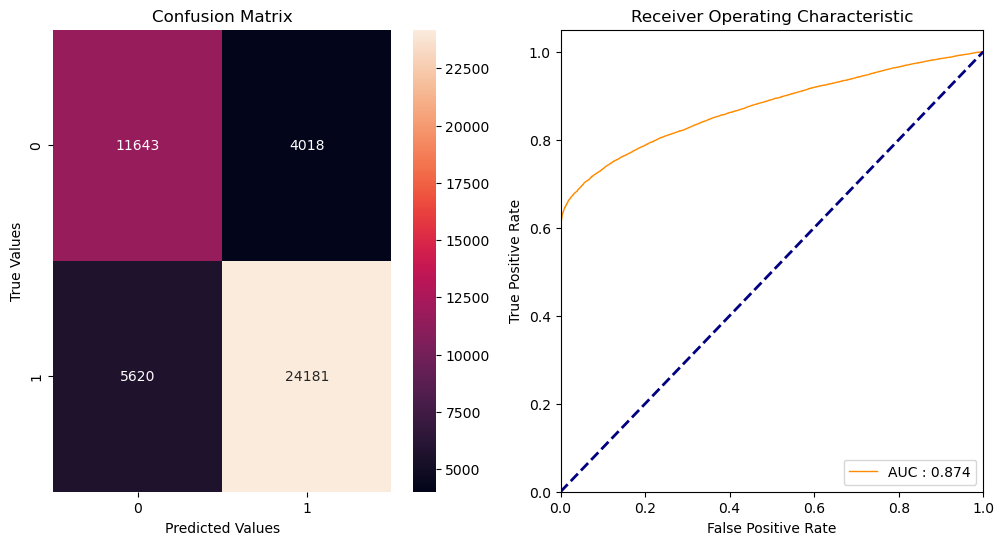

In [20]:
#6. XGBoost
churn_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42, n_jobs=-1)
churn_xgb.fit(X_train, y_train)
models.append(churn_xgb)
eval_metrics(churn_xgb, X_test, y_test)

In [21]:
from sklearn.model_selection import StratifiedKFold
# Model Comparison using K-Fold Cross Validation
result_col = ["Algorithm", "AUC Mean", "Bal Acc Mean", "Recall"]
model_results = pd.DataFrame(columns=result_col)

i = 0
for model in models:
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    cv_acc_results = cross_val_score(model, X_train, y_train,
                                     cv=skf, scoring="balanced_accuracy", n_jobs=-1)
    cv_auc_results = cross_val_score(model, X_train, y_train,
                                     cv=skf, scoring="roc_auc", n_jobs=-1)
    cv_recall_results = cross_val_score(model, X_train, y_train,
                                        cv=skf, scoring="recall", n_jobs=-1)
    

    model_results.loc[i] = [model.__class__.__name__,
                                    round(cv_auc_results.mean() * 100, 2),
                                    round(cv_acc_results.mean() * 100, 2),
                                    round(cv_recall_results.mean() * 100, 2)
                           ]
    i += 1

model_results = model_results.sort_values(by=['AUC Mean'], ascending=False)
print(model_results)

                    Algorithm  AUC Mean  Bal Acc Mean  Recall
5               XGBClassifier     87.31         76.97   82.15
3      RandomForestClassifier     82.81         70.78   86.47
4  GradientBoostingClassifier     79.96         66.30   89.35
1      DecisionTreeClassifier     72.93         72.93   82.30
2                  GaussianNB     71.77         61.16   89.79
0          LogisticRegression     66.13         56.83   91.34


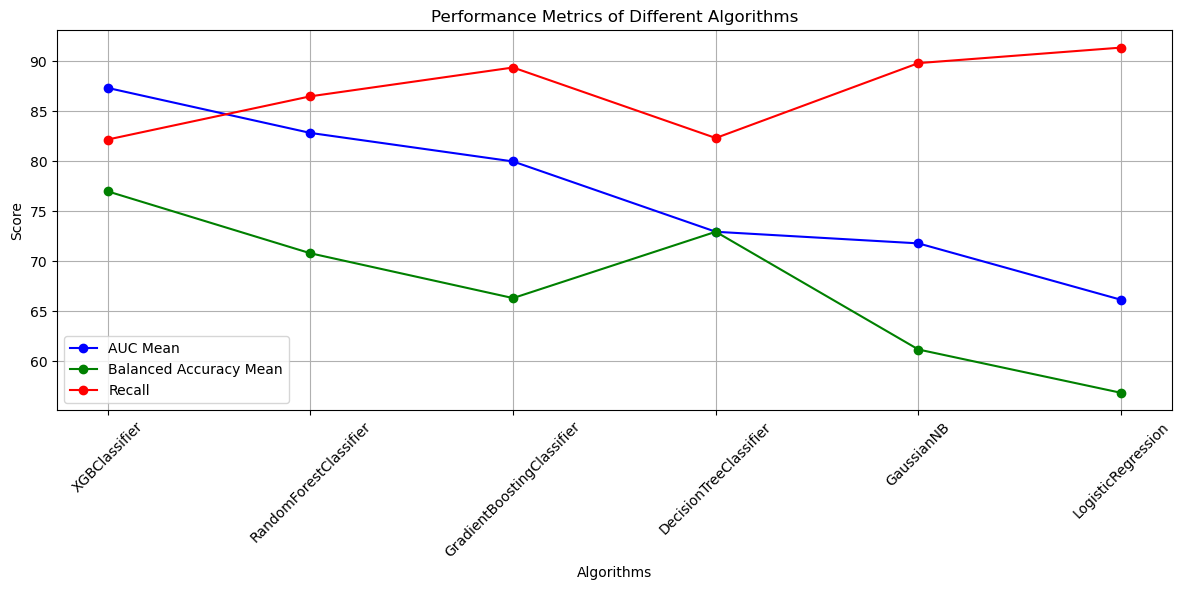

In [22]:
# Sort results by AUC score
model_results = model_results.sort_values(by=['AUC Mean'], ascending=False)

# Plot model performance
plt.figure(figsize=(12, 6))
plt.plot(model_results['Algorithm'], model_results['AUC Mean'], marker='o', label='AUC Mean', color='b')
plt.plot(model_results['Algorithm'], model_results['Bal Acc Mean'], marker='o', label='Balanced Accuracy Mean', color='g')
plt.plot(model_results['Algorithm'], model_results['Recall'], marker='o', label='Recall', color='r'),

plt.xticks(rotation=45)
plt.xlabel('Algorithms')
plt.ylabel('Score')
plt.title('Performance Metrics of Different Algorithms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# Define hyperparameter search space
rf_params_dist = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [10, 20, 30, None],  
    'max_features': ['sqrt', 'log2', None], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'class_weight': ['balanced'],  
    'ccp_alpha': [0.0, 0.01, 0.1]
}

# Initialize base model
churn_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Perform Randomized Search with Cross-Validation
rf_random = RandomizedSearchCV(
    churn_rf, 
    rf_params_dist, 
    n_iter=10,
    scoring='roc_auc', 
    cv=skf, 
    verbose=2,  
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
rf_random.fit(X_train, y_train)

# Get best parameters
best_params = rf_random.best_params_
print("Best Parameters for RF:", best_params)
print("Best Score for RF:", rf_random.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for RF: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'class_weight': 'balanced', 'ccp_alpha': 0.0}
Best Score for RF: 0.825607465145669


In [24]:
# Train the optimized model
churn_rf_optimal = RandomForestClassifier(
                                           n_estimators=best_params['n_estimators'],
                                           max_depth=best_params['max_depth'],
                                           max_features=best_params['max_features'],
                                           min_samples_split=best_params['min_samples_split'],
                                           min_samples_leaf=best_params['min_samples_leaf'],
                                           class_weight=best_params['class_weight'],
                                           ccp_alpha=best_params['ccp_alpha'],
                                           random_state=42,
                                           n_jobs=-1
                                          )

# Fit the model on training data
churn_rf_optimal.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features='log2',
                       min_samples_leaf=2, n_estimators=200, n_jobs=-1,
                       random_state=42)

Random Forest Model Evaluation:
Precision:  0.8102182792953792
Recall:  0.8519512768027918
F1 Score:  0.8305608714853525
ROC AUC Score:  0.8437832672668509


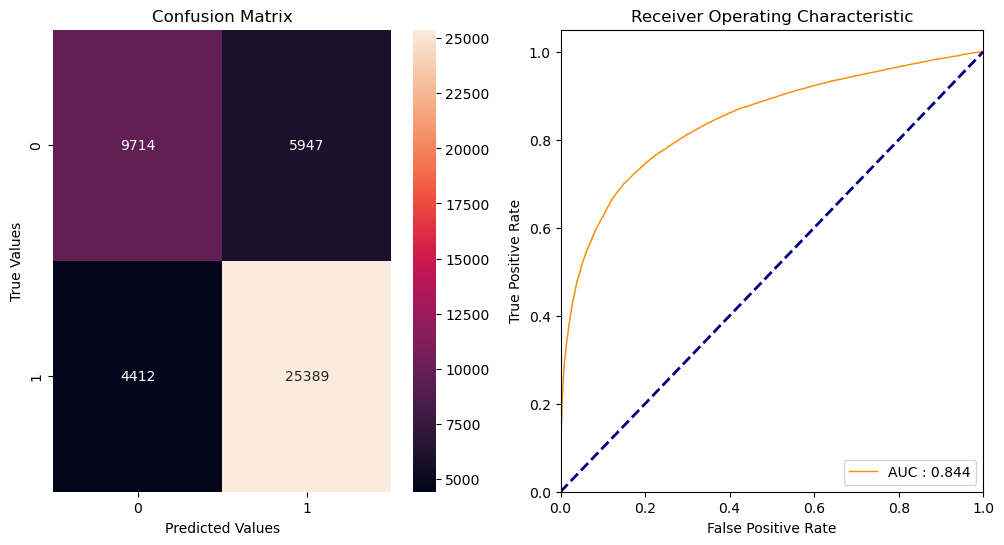

In [25]:
# Evaluate performance
print("Random Forest Model Evaluation:")
eval_metrics(churn_rf_optimal, X_test, y_test)

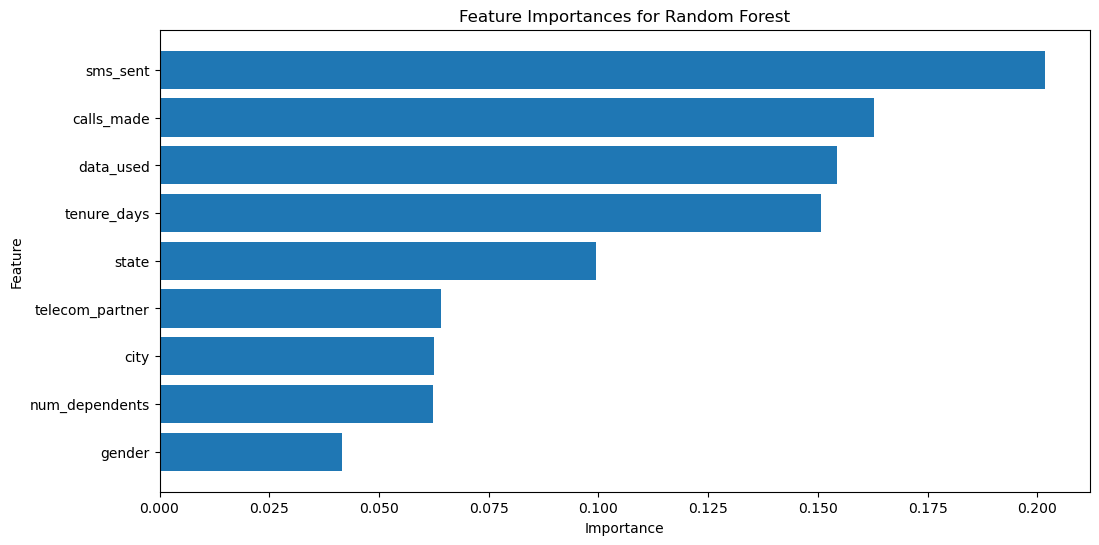

In [26]:
# Feature importance visualization for Random Forest
importances = churn_rf_optimal.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Random Forest')
plt.show()

In [37]:
# Define hyperparameter search space
xgb_params_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2], 
    'max_depth': [4, 5, 6, 7, 8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3], 
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 3, 5],  
    #'scale_pos_weight': [5, 10, 15],
    'subsample': [0.5, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0]
}

# Initialize base model
churn_xgb = xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), objective='binary:logistic', seed=42, n_jobs=-1)

# Perform Randomized Search
xgb_random = RandomizedSearchCV(
    churn_xgb,
    xgb_params_dist,
    scoring='roc_auc',
    cv=5,
    n_iter=20,  # Randomly search 20 combinations
    verbose=2,
    n_jobs=-1
)

# Fit RandomizedSearchCV
xgb_random.fit(X_train, y_train)

# Get best parameters
best_params = xgb_random.best_params_
print("Best Parameters for XGBoost:", best_params)
print("Best Score for XGBoost:", xgb_random.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters for XGBoost: {'subsample': 0.7, 'reg_lambda': 3, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.5}
Best Score for XGBoost: 0.8873583123618459


In [38]:
# Train the optimized model
churn_xgb_optimal = xgb.XGBClassifier(objective='binary:logistic',
                                  n_estimators=best_params['n_estimators'],
                                  learning_rate=best_params['learning_rate'],
                                  max_depth=best_params['max_depth'],
                                  min_child_weight=best_params['min_child_weight'],
                                  gamma=best_params['gamma'], 
                                  reg_alpha=best_params['reg_alpha'],
                                  reg_lambda=best_params['reg_lambda'],
                                  #scale_pos_weight=best_params['scale_pos_weight'],
                                  subsample=best_params['subsample'],
                                  colsample_bytree=best_params['colsample_bytree'],
                                  seed=42,
                                  n_jobs=-1
                                  #early_stopping_rounds=10
                                 )

# Fit the model on training data
churn_xgb_optimal.fit(X_train, y_train) 
                     #eval_set=[(X_test, y_test)],
                     #eval_metric="aucpr", 
                     #early_stopping_rounds=10, 
                     #verbose=True)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

XGBoost Model Evaluation:
Precision:  0.8919934518937421
Recall:  0.80450320459045
F1 Score:  0.8459923428430283
ROC AUC Score:  0.8883732175018624


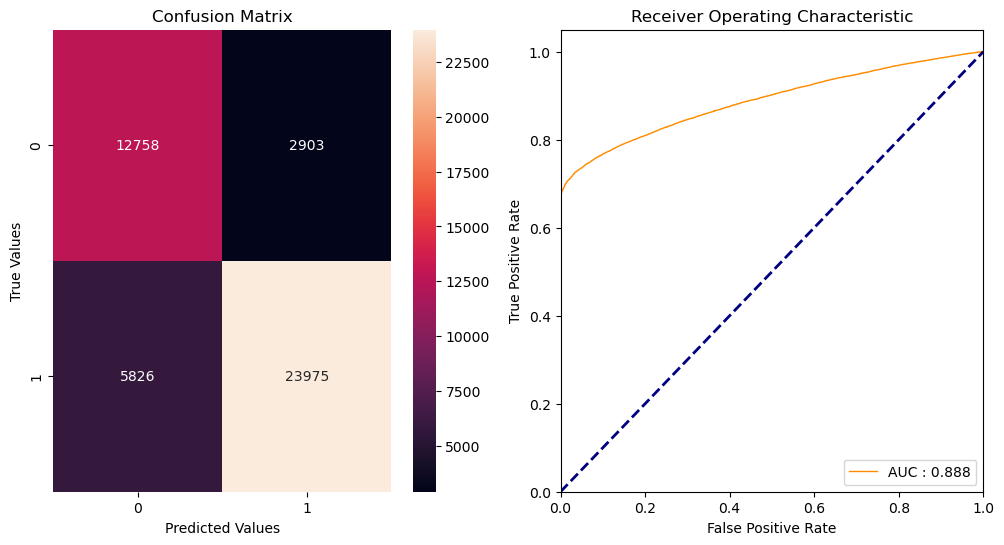

In [39]:
# Evaluate performance
print("XGBoost Model Evaluation:")
eval_metrics(churn_xgb_optimal, X_test, y_test)

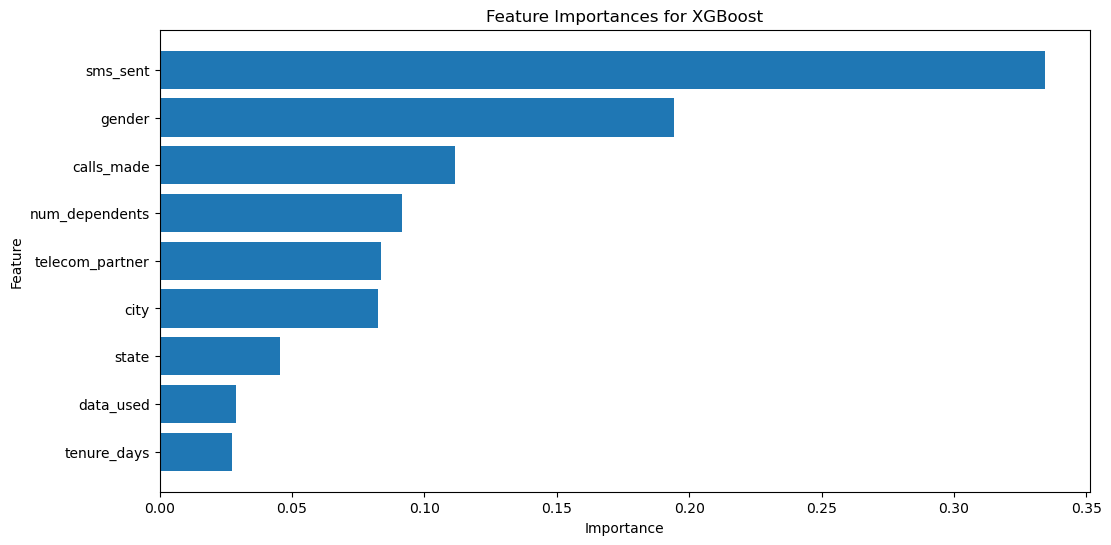

In [40]:
# Feature importance visualization for XGBoost
importances = churn_xgb_optimal.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for XGBoost')
plt.show()

In [41]:
import pickle

# Save the final XGBoost model to disk
pickle.dump(churn_xgb_optimal, open('churn_xgb_optimal.pkl', 'wb'))

In [42]:
# Save the final XGBoost model to disk
pickle.dump(churn_rf_optimal, open('churn_rf_optimal.pkl', 'wb'))